In [1]:
suppressWarnings(suppressMessages(library(Biostrings)))
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(plyr))
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(scales)
library(knitr)
library(IRdisplay)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
fills = c('A'='#ffd92f', 'C'='#4daf4a', 'G'='#e41a1c', 'U'='#377eb8', 'A:U'='#93da69', 'U:A'='#93da69', 'G:C'='#c1764a', 'C:G'='#c1764a', 'G:U'='#b26cbd', 'U:G'='#b26cbd', "A:C"='gray30', 'C:A'='gray30', 'A:G'='gray30', 'G:A'='gray30', 'C:U'='gray30', 'U:C'='gray30', 'A:A'='gray30', 'C:C'='gray30', 'G:G'='gray30', 'U:U'='gray30', 'A:-'='gray30', '-:A'='gray30', 'C:-'='gray30', '-:C'='gray30', 'G:-'='gray30', '-:G'='gray30', 'U:-'='gray30', '-:U'='gray30', '-'='gray60', '-:-'='gray60', 'N'='gray60', 'N:N'='gray60')

In [2]:
load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('isotype-specific.RData')
load('consensus-IDEs.RData')
load('clade-isotype-freqs.RData')
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
genome_table = read.delim('genomes-061517.tsv', sep='\t', stringsAsFactors=FALSE, header=FALSE, col.names=c("species", "species_long", "domain", "clade", "taxid"))

# Weird tRNAs in context of sequence features

List of weird tRNAs:

- Susan Ackerman's [Arg-UCU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Arg-TCT-4-1.html) in mouse. 
    - Only Arg-UCU without an intron.
    - See alignment for details, but it also includes C20a instead of T20a, G20b, C40 instead of T40, etc. 
    - Most importantly, it contains C50, but its mutation to T50 likely causes misfolding in the B6J mouse strain.
    - Conserved in human, and potentially all the way to zebrafish and Drosophila.
- [Lys-CUU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/genes/tRNA-Lys-CTT-1-1.html) in yeast. It's the only isodecoder for Lys-CUU. Can fold into an "F"-form able to be imported into the mitochondria.
- [Gly-GCC](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Gly-GCC-2-1.html), which is downregulated in B cell lymphoma cell lines (Maute paper). Represses RPA1, which is involved in DNA repair, DNA replication, and DNA damage response. Overexpression reduces proliferation and sensitizes cell to etoposide-induced DNA damage.
- Verify whether Lys tRNAs with A18:U55 and G19:U56 are indicative of conserved function.

## Code for extracting position-specific bit score differences

We need to (a) filter for the subset of tRNAs we're interested in, (b) create a multiple alignment -> covariance model (no need to calibrate), (c) align, (d) parse output, and (e) visualize.

In [3]:
calculate_position_specific_scores = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {
  # get subset of tRNAs and write to file
  subset = identities %>% select_('species', 'seqname', 'isotype', 'clade', 'anticodon', 'quality') %>% filter_('quality')
  if (clade != "") subset = subset %>% filter_(paste0("clade == '", clade, "'"))
  if (isotype != "") subset = subset %>% filter_(paste0("isotype == '", isotype, "'"))
  if (isotype != "" & anticodon != "") subset = subset %>% filter_(paste0("anticodon == '", anticodon, "'"))
  if (dim(subset)[1] < 5) return('Rare anticodon; could not generate consensus')
  euk_seqs = readDNAStringSet(filepath = '/projects/lowelab/users/blin/identity/euk-isotypes/euk-tRNAs.fa', format = 'fasta')
  names(euk_seqs) = str_replace(str_extract(names(euk_seqs), '\\S+'), '\\|', '_')
  writeXStringSet(euk_seqs[match(subset$seqname, names(euk_seqs))], filepath = 'subset.fa')

  # create covariance model
  system('cmalign -g --notrunc --matchonly -o subset.sto /projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm subset.fa > /dev/null')
  system('cmbuild --hand --enone -F subset.cm subset.sto > /dev/null')

  # remove intron from our tRNA
  #   align our tRNA to the numbering model
  seq = DNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, "-raw.fa"))
  system(paste('cmalign -g --notrunc --matchonly -o', paste0(seqname, "-raw.sto"), '/projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm', paste0(seqname, "-raw.fa"), " > /dev/null"))
  
  #  rewrite tRNA to file and realign to subset model
  seq = str_replace_all(str_extract(as.character(read.delim(paste0(seqname, '-raw.sto'))[2, ]), '[AGCU-]+$'), '-', '')
  seq = RNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, ".fa"))
  system(paste0('cmalign -g --notrunc --matchonly --tfile ', seqname, '.tfile -o ', seqname, '.sto subset.cm ', seqname, '.fa > /dev/null'))
    
  # parse output
  system(paste0('python parse-parsetree.py ', seqname, '.tfile > ', seqname, '.bits'))
  bits = read.table(paste0(seqname, '.bits'), header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '20b', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Input") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position))

  # generate consensus sequence. This is a multistep process.
  #   Create a new model that doesn't conform to numbering model. This is important because cmemit can't emit a consensus with gaps.
  system('cmemit --exp 5 -N 1000 -a subset.cm > subset-free.sto')
  system('cmbuild --enone -F subset-free.cm subset-free.sto > /dev/null')
  #   Next, emit and read in consensus sequence
  #   replace lowercase residues with uppercase. Used to replace with Ns, which would lead to the consensus scoring lower than 0. 
  system('cmemit -c subset-free.cm | perl -npe "if(/^[acguACGU]/){s/uc($1)/[agcu]/g}" > subset-cons.fa')
  system('cmalign -g --notrunc --matchonly --tfile subset-cons.tfile -o subset-cons.sto subset.cm subset-cons.fa > /dev/null')
  system('python parse-parsetree.py subset-cons.tfile > subset-cons.bits')

  bits = rbind(bits, read.table('subset-cons.bits', header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '20b', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Consensus") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position)))

  # compare consensus and our tRNA
  bits = bits %>% group_by(Position) %>%
    arrange(Source) %>% 
    summarize(Bits = Bits[2] - Bits[1], Consensus = Identity[1], Identity = Identity[2]) %>% 
    ungroup()    

  # clean up
  system('rm subset.sto subset.cm subset.fa')
  system('rm subset-cons.fa subset-cons.bits subset-cons.tfile subset-cons.sto')
  system('rm subset-free.sto subset-free.cm')
  system(paste0('rm ', seqname, '.fa ', seqname, '-raw.fa ', seqname, '.bits ', seqname, '.sto ', seqname, '-raw.sto ', seqname, '.tfile')) 

  return(bits)
}
    
calculate_scores_multiplex = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {

  bits = calculate_position_specific_scores(seq, seqname, clade = "", isotype = "", anticodon = "") %>% 
    mutate(Clade = "Eukaryota", Isotype = "All isotypes", Anticodon = "")

  if (clade != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype = "", anticodon = "") %>%
                 mutate(Clade = clade, Isotype = "All isotypes", Anticodon = ""))
  }
  if (isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype, anticodon = "") %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (clade != "" & isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = clade, isotype = isotype, anticodon = "") %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype = isotype, anticodon = anticodon) %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = anticodon))
  }
  if (clade != "" & isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype, anticodon) %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon))
  }
  
  return(bits %>% mutate(tRNA = seqname))
}
    
calculate_scores_multiseq = function(seqs = "", clade = "Eukaryota", isotype = "", anticodon = "") {  
  multi_bits = data.frame(Position = character(0), Bits = character(0), Identity = character(0), Consensus = character(0), Clade = character(0), Isotype = character(0), Anticodon = character(0))
  for (i in 1:length(seqs)) {
    bits = calculate_position_specific_scores(seqs[i], names(seqs)[i], clade, isotype, anticodon)
    if (typeof(bits) == "character" && bits == 'Rare anticodon; could not generate consensus') next
    bits = bits %>% mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon, tRNA = names(seqs)[i])
    multi_bits = rbind(multi_bits, bits)
  }
  
  return(multi_bits)
}

In [4]:
plot_bitchart = function(bits) {
  bits %>% mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
    ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
      geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
      scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                           values = c(0, 2/3, 1),
                           limits = c(-15, 0)) +
      scale_color_manual(values = c("black" = "black", "white" = "white")) +
      scale_alpha(range = c(0.4, 1)) +
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position = "bottom") + 
      guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10)) + 
      labs(y = "")
}

# Arg-UCU

First, let's look at how well this tRNA matches the consensus for different clades and isotypes:

In [5]:
bits = calculate_scores_multiplex(seq = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                  seqname = "hg19_chr1.trna84-ArgTCT",
                                  clade = "Mammalia", 
                                  isotype = "Arg",
                                  anticodon = "TCT")

bits = bits %>% mutate(Clade = as.factor(Clade), Isotype = as.factor(Isotype), Anticodon = as.factor(Anticodon), Consensus = as.factor(Consensus), Identity = as.factor(Identity)) %>%
  mutate(tRNA = paste0(Clade, " / ", Isotype, " ", Anticodon)) %>%
  select(Position, Clade, tRNA, Bits, Consensus, Identity)

In [6]:
plot = bits %>% mutate(temp = Identity, Identity = Consensus) %>% 
  mutate(Consensus = temp) %>%
  select(-temp) %>%
  rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Bits = 0, tRNA = "Input seq")) %>% 
  mutate(tRNA = factor(tRNA, levels = rev(c("Input seq", rev(unique(bits$tRNA)))))) %>%
  plot_bitchart

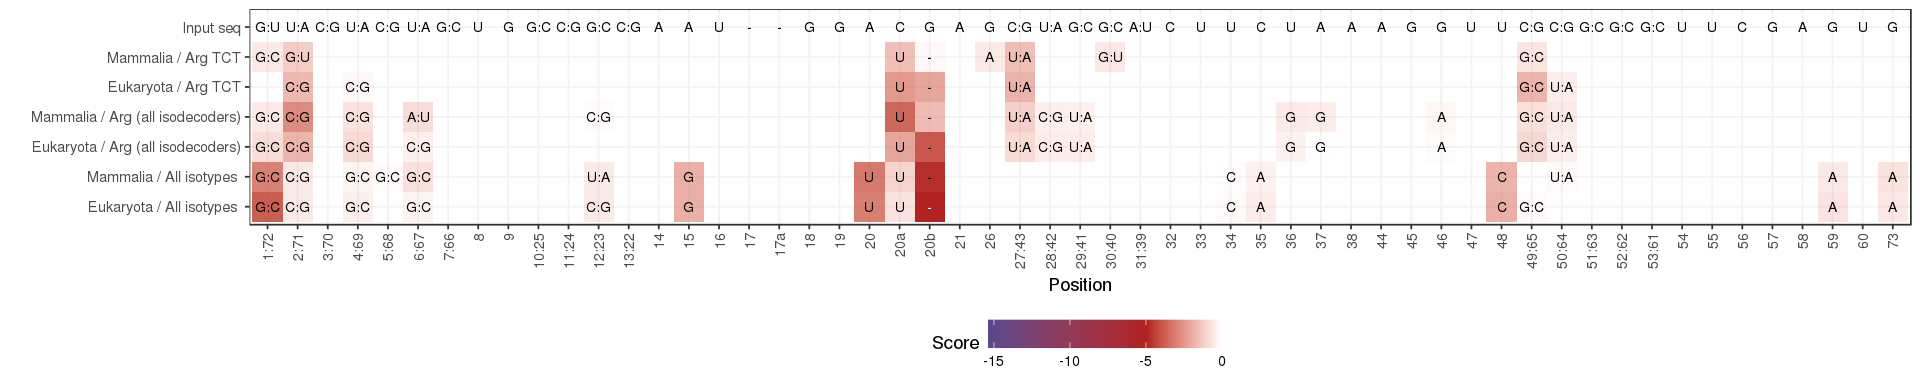

In [7]:
options(repr.plot.width = 16, repr.plot.height = 3.2)
plot

In [8]:
bits = calculate_scores_multiseq(seqs = c("Human-Arg-TCT-4-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Human-Arg-TCT-1-1" = "GGCTCCGTGGCGCAATGGAtAGCGCATTGGACTTCTAgaggctgaaggcATTCAAAGGtTCCGGGTTCGAGTCCCGGCGGAGTCG",
                                          "Human-Arg-TCT-2-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgtgacgaatagagcaATTCAAAGGtTGTGGGTTCGAATCCCACCAGAGTCG",
                                          "Human-Arg-TCT-3-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgctgagcctagtgtggtcATTCAAAGGtTGTGGGTTCGAGTCCCACCAGAGTCG"),
                                clade = "", isotype = "Arg", anticodon = "TCT")

In [9]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus", unique(bits$tRNA))))) %>%
  plot_bitchart

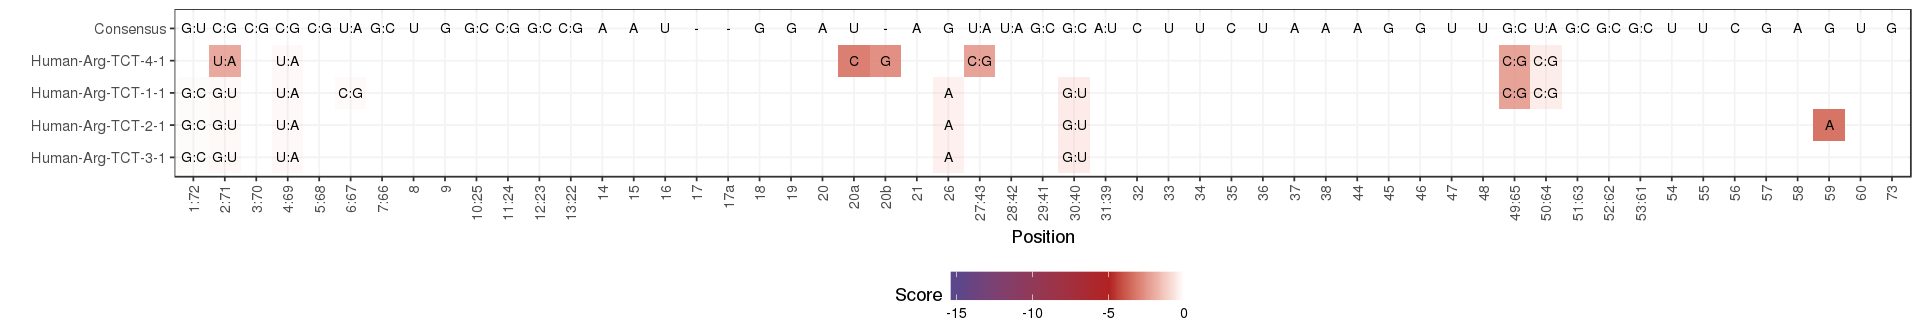

In [10]:
options(repr.plot.width = 16, repr.plot.height = 2.8)
plot

In [11]:
bits = calculate_scores_multiseq(seqs = c("Human-Arg-TCT-4-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Human-Arg-TCT-1-1" = "GGCTCCGTGGCGCAATGGAtAGCGCATTGGACTTCTAgaggctgaaggcATTCAAAGGtTCCGGGTTCGAGTCCCGGCGGAGTCG",
                                          "Human-Arg-TCT-2-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgtgacgaatagagcaATTCAAAGGtTGTGGGTTCGAATCCCACCAGAGTCG",
                                          "Human-Arg-TCT-3-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgctgagcctagtgtggtcATTCAAAGGtTGTGGGTTCGAGTCCCACCAGAGTCG",
                                          "Chimp-Arg-TCT-3-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Mouse-Arg-TCT-5-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCTGGGTTCGAGTCCCGGCAGAGATG",
                                          "Lizard-chrUn_GL344271.trna1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Frog-Arg-TCT-9-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Lamprey-GL477809.trna2-ArgTCT" = "GTCTCTGTGGCGCAATGGAcaAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Zebrafish-chr2.trna417-ArgTCT" = "GTCTCTGTGGCGCAATGGAatAGCGCGCTGGACTTCTAATCCAGAGGcTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Sea-urchin-Scaffold10723.trna1-ArgTCT" = "GTCCCTGTGGCGCAATGGAttAGCGCATTGGACTTCTAATTCAAAGGtTCCGGGTTCGAGTCCCGGCAGGGATG",
                                          "Drosophila-tRNA-Arg-TCT-1-1" = "GTCCCTTTGGCGCAGAGGAtAGCGCGTTGGACTTCTAATCCAAAGGtCGCGGGTTCGATCCCCGCAAGGGATG"),
                                 clade = "", isotype = "Arg", anticodon = "TCT")

bits = bits %>% select(Position, Bits, Identity, Consensus, tRNA) %>%
  mutate(tRNA = revalue(tRNA, c("Human-Arg-TCT-1-1" = "Arg-TCT-1-1",
                                "Human-Arg-TCT-2-1" = "Arg-TCT-2-1",
                                "Human-Arg-TCT-3-1" = "Arg-TCT-3-1",
                                "Human-Arg-TCT-4-1" = "Arg-TCT-4-1",
                                "Chimp-Arg-TCT-3-1" = "Chimp",
                                "Mouse-Arg-TCT-5-1" = "Mouse",
                                "Lizard-chrUn_GL344271.trna1" = "Lizard",
                                "Frog-Arg-TCT-9-1" = "Frog",
                                "Lamprey-GL477809.trna2-ArgTCT" = "Lamprey",
                                "Zebrafish-chr2.trna417-ArgTCT" = "Zebrafish",
                                "Sea-urchin-Scaffold10723.trna1-ArgTCT" = "Sea urchin",
                                "Drosophila-tRNA-Arg-TCT-1-1" = "Drosophila")))

In [12]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Eukaryotic Arg-TCT Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Eukaryotic Arg-TCT Consensus", "Arg-TCT-1-1", "Arg-TCT-2-1", "Arg-TCT-3-1", "Arg-TCT-4-1", "Chimp", "Mouse", "Lizard", "Frog", "Lamprey", "Zebrafish", "Sea urchin", "Drosophila")))) %>%
  plot_bitchart

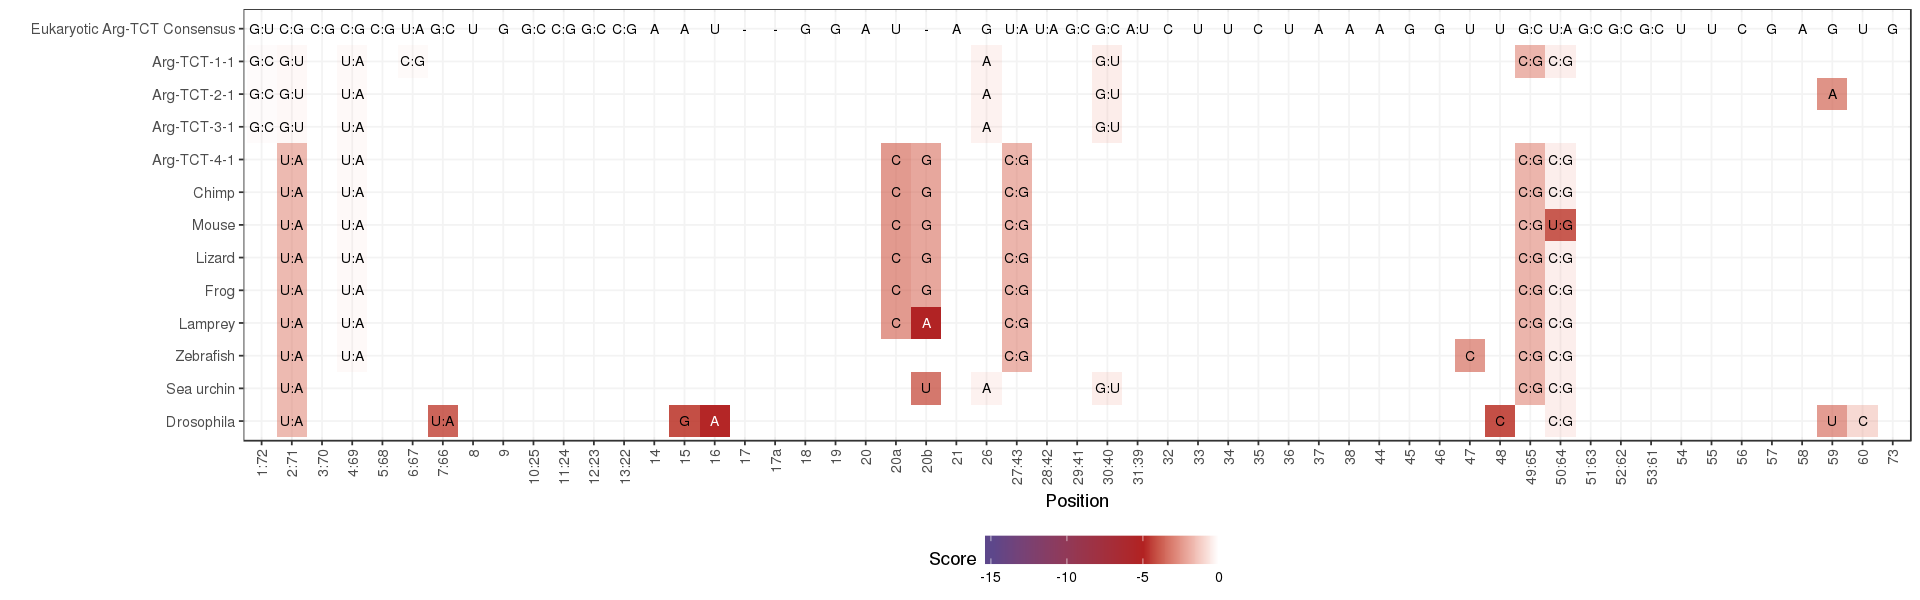

In [13]:
options(repr.plot.width = 16, repr.plot.height = 5)
plot

We don't know for certain when the tRNA stops being functional, but we do know that:

- C20a and G20b are weird in eukaryotes
- C27:G43 is weird for Arg in eukaryotes
- C49:G65 is also weird for Arg in eukaryotes, but not unheard of
- U2:A71 distinguishes this tRNA from other Arg-TCTs

What's special about this tRNA?

In mouse, it's required for proper translation. Neurodegeneration is caused when this tRNA is gone, causing ribosome stalling (rescue factor GTPBP2 is also gone). No other TCT does this.

The B6J genome contains U50 instead of C50. Either this and/or something else causes misprocessing of this tRNA. Translation rates are same but there's some sort of processing defect.

Notice that although the Ackerman paper claims it folds properly, the folding engines in EteRNA disagree with that at free energy, regardless of identity at 50.

<img src='figures/vienna.png' style='width:300px;display:inline;'> <img src='figures/vienna-force.png' style='width:300px;display:inline;'>

Also noteworthy - there are significant interactions between trailer and leader sequences. Putting the upstream and downstream sequences result in many, many contacts.

According to [euk-tRNAs](euk-tRNAs.ipynb), 20b is pretty rare except in serine tRNAs. Could 20b have something to do with the processing defect? It's also the only tRNA without an intron. One possible explanation... 20b causes the tRNA to misfold and prevent proper intron processing. It's why time and time again there are no introns in this tRNA, across different species.

But the paper makes a compelling case for U50 as the main culprit. Is U50:G64 bad?

In [14]:
bits = calculate_scores_multiplex(seq = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCTGGGTTCGAGTCCCGGCAGAGATG",
                                  seqname = "mouse",
                                  clade = "Mammalia", 
                                  isotype = "Arg",
                                  anticodon = "TCT")

bits = bits %>% mutate(Clade = as.factor(Clade), Isotype = as.factor(Isotype), Anticodon = as.factor(Anticodon), Consensus = as.factor(Consensus), Identity = as.factor(Identity)) %>%
  mutate(tRNA = paste0(Clade, " / ", Isotype, " ", Anticodon)) %>%
  select(Position, Clade, tRNA, Bits, Consensus, Identity)

In [15]:
plot = bits %>% mutate(temp = Identity, Identity = Consensus) %>% 
  mutate(Consensus = temp) %>%
  select(-temp) %>%
  rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Bits = 0, tRNA = "Input seq")) %>% 
  mutate(tRNA = factor(tRNA, levels = rev(c("Input seq", rev(unique(bits$tRNA)))))) %>%
  plot_bitchart

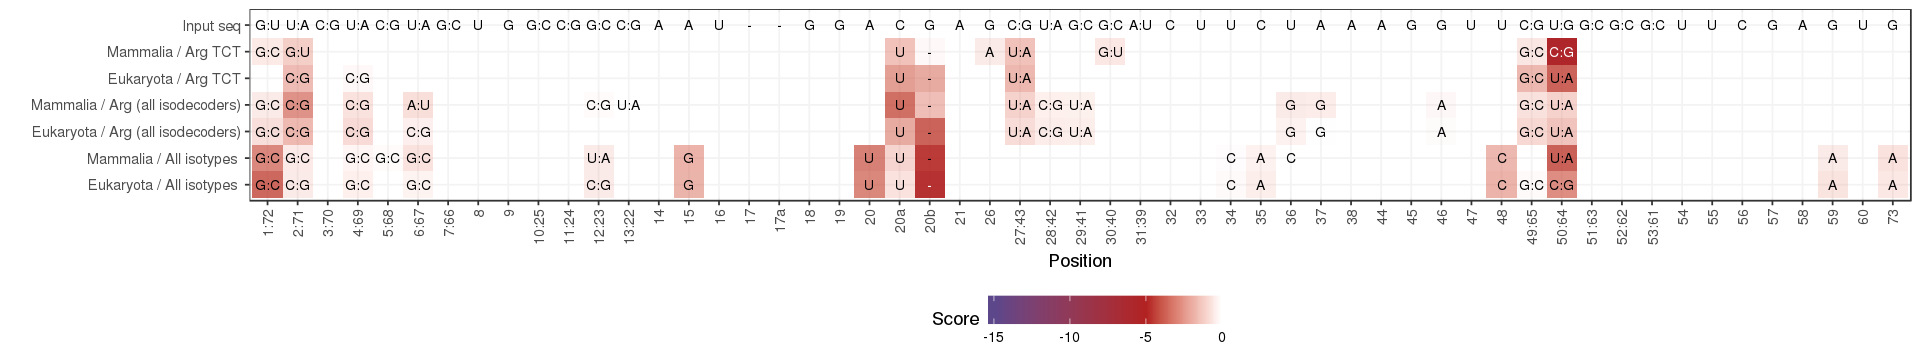

In [16]:
options(repr.plot.width = 16, repr.plot.height = 3)
plot

It actually looks like there's a bit of selective pressure against U50:G64. The entire T arm is mostly consisted of strong pairs. Then again, all of the stems list a strong pair for all paired residues across all eukaryotes and isotypes. Not surprising.

Let's work through frequencies of the other divergent features (U2:A71, C20a, G20b, C27:G43, and C49:G65):

In [17]:
identities %>% filter(!restrict, clade == "Mammalia", isotype == "Arg", anticodon == "TCT")  %>%
  select(species, X2.71, X20a, X20b, X27.43, X49.65) %>% gather(position, feature, -species) %>%
  group_by(position, feature) %>% tally %>% spread(feature, n, 0)

Warning message:
“attributes are not identical across measure variables; they will be dropped”

,position,-,C,C:C,C:G,G,G:C,G:U,U,U:A,U:C,U:G
1,X2.71,0,0,0,8,0,2,174,0,44,0,0
2,X20a,2,44,0,0,0,0,0,182,0,0,0
3,X20b,184,1,0,0,43,0,0,0,0,0,0
4,X27.43,0,0,0,44,0,0,0,0,182,1,1
5,X49.65,0,0,1,74,0,150,3,0,0,0,0


In [18]:
identities %>% filter(!restrict, clade == "Mammalia", isotype == "Arg", anticodon == "TCT")  %>%
  mutate(special = (X2.71 == "U:A" & X20a == "C" & X20b == "G" & X27.43 == "C:G" & X49.65 == "C:G" & intron == 0)) %>%
  group_by(species, special) %>% tally %>% spread(special, n, 0)

,species,FALSE,TRUE
1,ailMel1,5,1
2,balAcu1,5,1
3,bosTau8,4,1
4,calJac3,3,1
5,canFam3,5,1
6,cavPor3,4,1
7,cerSim1,5,1
8,criGri1,4,1
9,dasNov3,4,1
10,dipOrd1,2,1


All mammals contain at least one Arg-TCT with these features.

_Can the U50 mutation, in conjunction with the tRNA's unique sequence features, explain its inability to be processed?_ It has to, since the tRNA is not recognized by 3' and 5' processing enzymes.

La typically assists with proper folding, but doesn't because of leader/trailer interactions. In fact, leader/trailer interactions are conserved:

```
Chimp tRNA-Arg-TCT-3-1: 5' gatgctgtgtgtgtggtgag -- tRNA -- gtcacctggcaggtgcctct 3'
    Leader  3' tRNA --  gagtggtgt-gtgtg 5'
                         ||||| || || ||
    Trailer 3' tRNA -- Ggtcacc-tggca-ggt 5'

Mouse tRNA-Arg-TCT-3-1: 5' GATGCTGTGTGTGTGGTGAG -- tRNA -- ATCACCTGGCATGTGCCTCT 3'
    Leader  3' tRNA --  GAGTGGTGT-GTGTG 5'
                         ||||| || |||||
    Trailer 3' tRNA -- GATCACC-TGGCATGT 5'

Lizard chrUn_GL344271.trna1-ArgTCT: 5' ttgtggtgag -- tRNA -- gtctccagga 3'
    Leader  3' tRNA --  GAGTGGTGTT 5'
                         || ||| ||
    Trailer 3' tRNA -- GGTCTCCA-GG 5'

Frog tRNA-Arg-TCT-9-1: 5' GATGCTGAGCGTGCGGTGAG -- tRNA -- GTTCCCACTGCGTTCTTTTG 3'
    Leader  3' tRNA --  GAGTGGCGTGCG-AG 5'
                         || || | ||| ||
    Trailer 3' tRNA -- GGTTCCCAC-TGCGTT 5'

Lamprey GL477809.trna2-ArgTCT: 5' tgccggtggc -- tRNA -- agcatggcta 3'
    Leader  3' tRNA --  cggtggccg-t 5'
                          ||| ||| |
    Trailer 3' tRNA -- Gagcat-ggcta 5'

Sea urchin Scaffold10723.trna1-ArgTCT: 5' ttgtgccaaa -- tRNA -- gcctacattt 3'
    Leader  3' tRNA --  aaaccgtgtt 5'
                             |||
    Trailer 3' tRNA -- Ggcctacattt 5'
```

In fact, this tRNA in human (Arg-TCT-4) has the best conserved leaders/trailers, among both Arg-TCTs and all Arg tRNAs.

![Conservation](figures/arg-tct-conservation.png)

Lastly, the T and D loops are enriched for strong interactions (+1 C:G) in this particular Arg-TCT tRNA. This indicates some trouble with proper formation of stem-loops. With the mutation to U50:G64, the T stem may be weakened enough that it doesn't form properly. RNase P specifically recognizes the elbow - so the tRNA may not be folding properly.

Position 50 is modified to m<sup>5</sup>C in Gly-GCC in yeast and Leu-CAA in human at multiple sites.

In summary, here's the hypothesis:

1. La does not typically bind this tRNA due to conserved leader/trailer interactions.
2. This tRNA instead relies on its unique sequence features for proper processing: strong loops, 20b, and (possibly) leader/trailer interactions.
3. A mutation to U50 disrupts the already delicate folding, and causes a defect in processing.

As for the other Arg-TCT tRNAs? Why is there ribosome stalling if the other Arg-TCTs are expressed (40% of Arg-TCTs) in the brain as well? Well, it's not so much because of a lack of Arg-TCT for decoding, it's because this Arg-TCT clogs up and depletes available ribosomes without ribosome release factors.

# Lys-CTT in yeast

The MERRF mutation occurs at the 50th nucleotide and at position 55 (A->G mutation) of human mito-Lys-TTT. The D-loop is truncated 3 nucleotides long, so the 18-55/19-56 interaction doesn't exist, or is substituted somehow. This mutation breaks recognition or processing by several enzymes: the synthetase (hypoaminoacylation), modification (hypomodified wobble), and the ribosome (premature translation termination).

Human mitochondria have not been shown to import tRNAs in vivo. Import of yeast Lys-CTT into human mitochondria has been performed, and requires enolase and pre-MSK (precursor to mitochondrial lysine synthetase).

<img src='figures/mito-trna-import.png' style='width: 40%'>

What sequence features are required or helpful for a tRNA to be reshaped into an F-form? A study by [Entelis et al. 2010](http://dx.doi.org/10.1261/rna.1914110) involving randomized aptamers supports a strong F-stem, a strong D-loop, and a long hairpin:

```
.........((((........))))....(((((((((((....))))))))))).((((((......))))))..
         |----D-loop----|    |------Long hairpin------| |-----F-stem-----|
```

Mitochondrial import efficiency tracks closely with the efficacy of this alternate fold. The F-stem is unusually CG/GC rich, and consists of the stretch from 69-74 (includes C from CCA tail) paired with 56-62. 

The main question we would _like_ to ask is, **how conserved are F-form tRNAs**?

If we wanted to find more F-folding tRNAs, a covariance model is more suitable. Overall, this case (1-5% of tRNA pool, need to consider modifications in folding, 3D structure prediction, sequence features are well studied) is not a textbook case of analyzing sequence features with more context.

# POP1 intronic tRNA

In [19]:
bits = calculate_scores_multiplex(seq = "GGTCTTGTGCTCAGTGGAAGCCTCTGTCTGACCaTACAGATGaTCCAGGTTCGAATCCTGGCAAGGCCA",
                                  seqname = "POP1-intron",
                                  clade = "Mammalia", 
                                  isotype = "",
                                  anticodon = "")

bits = bits %>% mutate(Clade = as.factor(Clade), Isotype = as.factor(Isotype), Anticodon = as.factor(Anticodon), Consensus = as.factor(Consensus), Identity = as.factor(Identity)) %>%
  mutate(tRNA = paste0(Clade, " / ", Isotype)) %>%
  select(Position, Clade, tRNA, Bits, Consensus, Identity)

In [20]:
plot = bits %>% mutate(temp = Identity, Identity = Consensus) %>% 
  mutate(Consensus = temp) %>%
  select(-temp) %>%
  rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Bits = 0, tRNA = "Input seq")) %>% 
  mutate(tRNA = factor(tRNA, levels = rev(c("Input seq", rev(unique(bits$tRNA)))))) %>%
  plot_bitchart

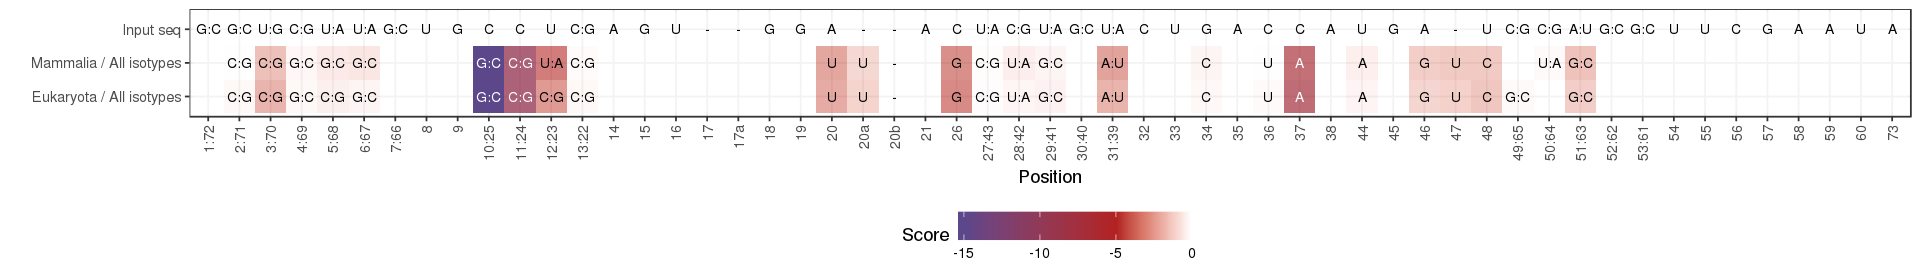

In [21]:
options(repr.plot.width=16, repr.plot.height=2.3)
plot

This tRNA clearly does not function as a normal tRNA, so analysis of the sequence features will naturally be a bit limited.

# tDRs acting as miRNAs

## Thr-AGT-1-1 (mir-3676)

Fragment processing indicates that Thr-AGT-1-1 is cut in the D loop between position 19 and 20. Leader/trailer sequences pair somewhat:

```
Trailer   TTTCGCACCCCCTTTGTGCC A73  -- tRNA
                         | |||
Leader    ATCCTAAGCGTCTTTC-CGG  C  -- tRNA
```


## Gly-GCC-2 / CU1276

Fragment processing indicates that Gly-GCC-2 is cut in the D loop between position 54 and 55. Leader/trailer sequences do not pair at all.

In [22]:
bits = calculate_scores_multiseq(seqs = c('Gly-GCC-1-1' = 'GCATGGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCCATGCA',
                                          'Gly-GCC-2-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA',
                                          'Gly-GCC-3-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTTGATTCCCGGCCAGTGCA',
                                          'Gly-GCC-4-1' = 'GCATAGGTGGTTCAGTGGTAGAATTCTTGCCTGCCACGCAGGAGGCCCAGGTTTGATTCCTGGCCCATGCA'),
                                          clade = "", isotype = "Gly", anticodon = "GCC")

In [23]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus", unique(bits$tRNA))))) %>%
  plot_bitchart

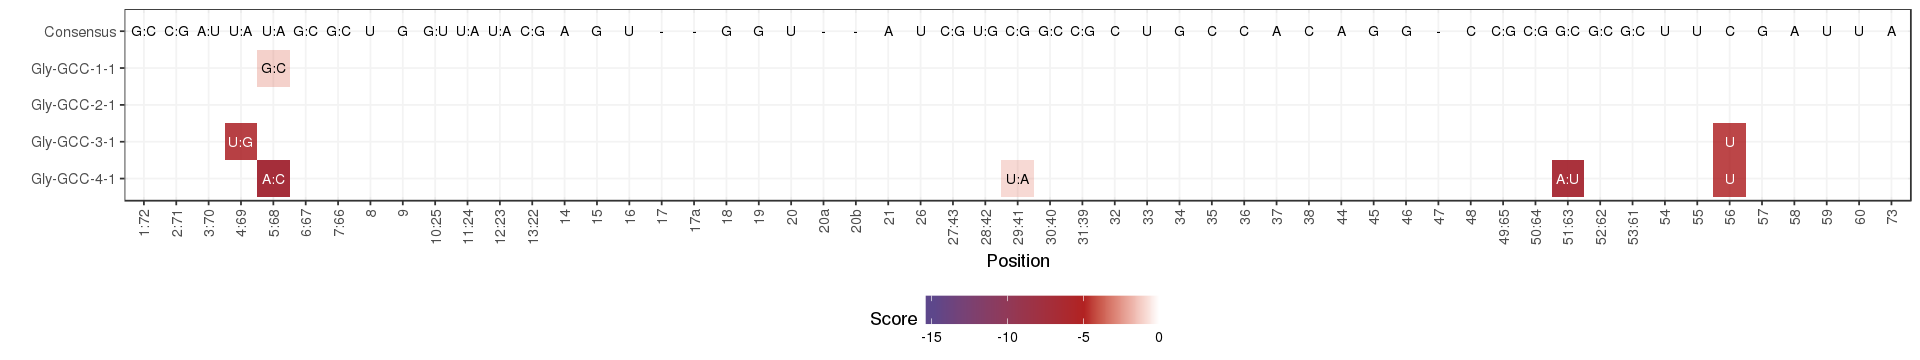

In [24]:
options(repr.plot.width=16, repr.plot.height=3)
plot

In [25]:
bits = calculate_scores_multiseq(seqs = c('Gly-GCC-1-1' = 'GCATGGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCCATGCA',
  'Gly-GCC-2-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA',
  'Gly-GCC-3-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTTGATTCCCGGCCAGTGCA',
  'Gly-GCC-4-1' = 'GCATAGGTGGTTCAGTGGTAGAATTCTTGCCTGCCACGCAGGAGGCCCAGGTTTGATTCCTGGCCCATGCA',
  'Gly-GCC-5-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCATGCGGGCGGCCGGGCTTCGATTCCTGGCCAATGCA',
  'Gly-CCC-1-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTCCCACGCGGGAGACCCGGGTTCAATTCCCGGCCAATGCA',
  'Gly-CCC-2-1' = 'GCGCCGCTGGTGTAGTGGTATCATGCAAGATTCCCATTCTTGCGACCCGGGTTCGATTCCCGGGCGGCGCA',
  'Gly-CCC-3-1' = 'GCATTGGTGGTTCAATGGTAGAATTCTCGCCTCCCACGCAGGAGACCCAGGTTCGATTCCTGGCCAATGCA',
  'Gly-CCC-4-1' = 'GCGTTGGTGGTTTAGTGGTAGAATTCTCGCCTCCCATGCGGGAGACCCGGGTTCAATTCCCGGCCACTGCA',
  'Gly-CCC-5-1' = 'GCCTTGGTGGTGCAGTGGTAGAATTCTCGCCTCCCACGTGGGAGACCCGGGTTCAATTCCCGGCCAATGCA',
  'Gly-TCC-1-1' = 'GCGTTGGTGGTATAGTGGTtAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
  'Gly-TCC-2-1' = 'GCGTTGGTGGTATAGTGGTgAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
  'Gly-TCC-3-1' = 'GCGTTGGTGGTATAGTGGTaAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
  'Gly-TCC-4-1' = 'GCGTTGGTGGTATAGTGGTgAGCATAGTTGCCTTCCAAGCAGTTGACCCGGGCTCGATTCCCGCCCAACGCA'),
  clade = "Mammalia", isotype = "Gly", anticodon = "")

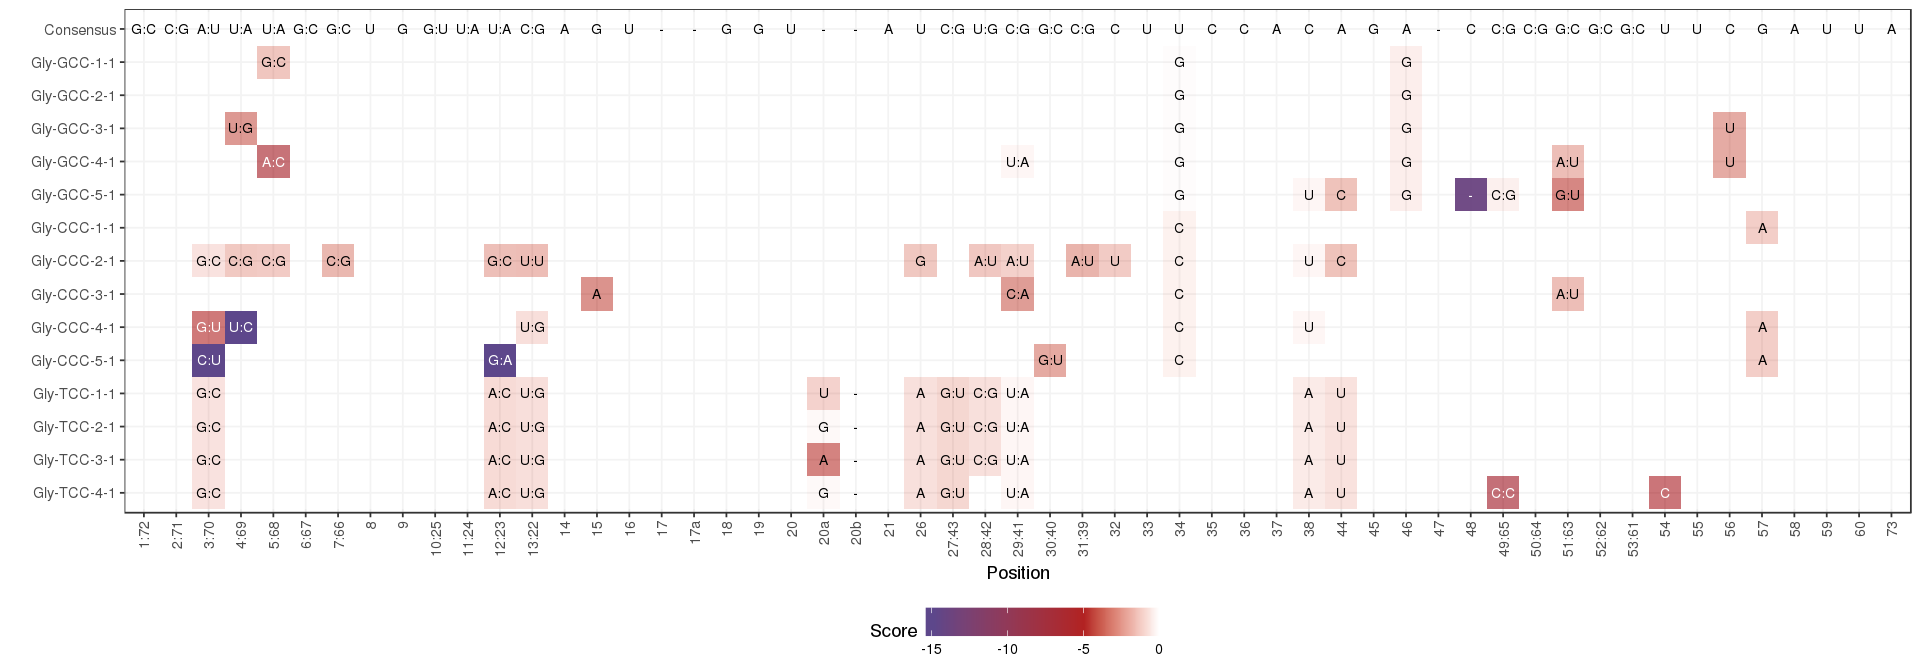

In [26]:
options(repr.plot.width=16, repr.plot.height=5.6)
bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus", unique(bits$tRNA))))) %>%
  plot_bitchart

## Ile-TAT-2-3 (Hasler et al. 2016)

This tRNA is known to pair its leader/trailer sequences.

In [27]:
bits = calculate_scores_multiseq(seqs = c("Ile-TAT-1" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAtgacagtgcgagcggagcaATGCCGAGGtTGTGAGTTCGATCCTCACCTGGAGCA",
                                          "Ile-TAT-2" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAcagcagtacatgcagagcaATGCCGAGGtTGTGAGTTCGAGCCTCACCTGGAGCA",
                                          "Ile-TAT-3" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAagacagtgcacctgtgagcaATGCCGAGGtTGTGAGTTCAAGCCTCACCTGGAGCA"),
                                clade = "", isotype = "Ile", anticodon = "TAT")

In [28]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus", unique(bits$tRNA))))) %>%
  plot_bitchart

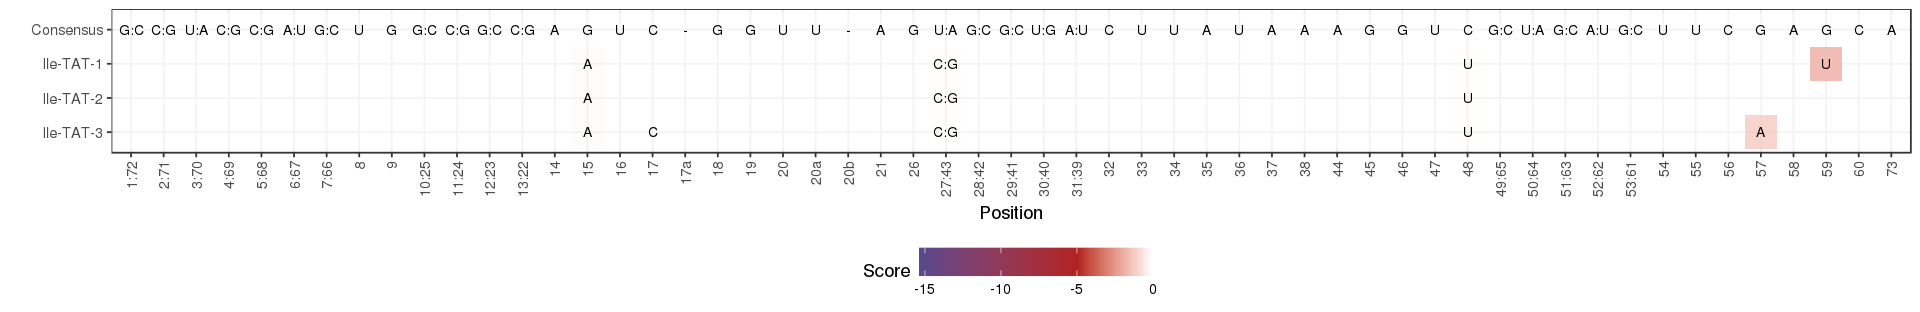

In [29]:
options(repr.plot.width=16, repr.plot.height=2.6)
plot

<img src="http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/images/hg19-chr2.tRNA5-IleTAT.gif" style='width:200px;display:inline'>
<img src="http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/images_MFE/hg19-tRNA-Ile-TAT-2-1-MFE.gif" style='width:200px;display:inline'>

## Pro-CGG-2-1 (Hasler et al. 2016)

This tRNA was also shown to be cleaved upon La knockdown in the same paper (Figure 3).

# Ser-GCT-6-1

In [30]:
bits = calculate_scores_multiseq(seqs = c("Ser-GCT-1-1" = "GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCACCCTCGTCG",
                                          "Ser-GCT-2-1" = "GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCACCTTCGTCG",
                                          "Ser-GCT-3-1" = "GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTTTGCACGCGTGGGTTCGAATCCCATCCTCGTCG",
                                          "Ser-GCT-6-1" = "GGAGAGGCCTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCATCCTCGTCG"),
                                clade = "", isotype = "Ser", anticodon = "GCT")

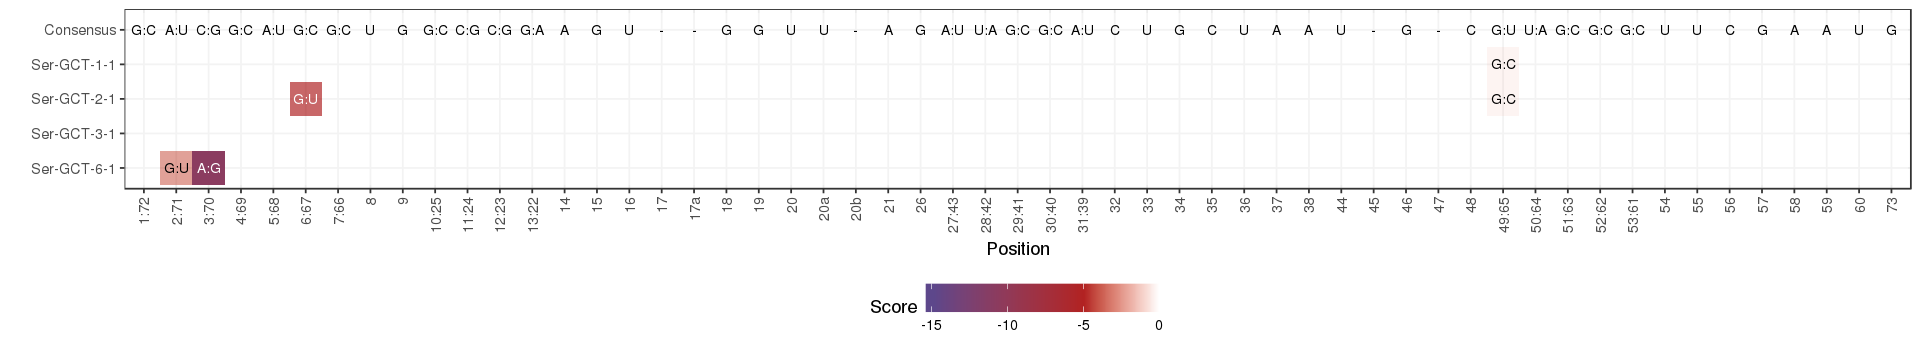

In [31]:
options(repr.plot.width=16, repr.plot.height=2.9)
bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus", unique(bits$tRNA))))) %>%
  plot_bitchart

# Glu-TTC-5-1

In [32]:
bits = calculate_scores_multiseq(seqs = c('Glu-TTC-1-1' = 'TCCCATATGGTCTAGCGGTtAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGACTCCCGGTATGGGAA', 
'Glu-TTC-2-1' = 'TCCCACATGGTCTAGCGGTtAGGATTCCTGGTTTTCACCCAGGCGGCCCGGGTTCGACTCCCGGTGTGGGAA', 
'Glu-TTC-3-1' = 'TCCCTGGTGGTCTAGTGGCtAGGATTCGGCGCTTTCACCGCCGCGGCCCGGGTTCGATTCCCGGCCAGGGAA', 
'Glu-TTC-4-1' = 'TCCCTGGTGGTCTAGTGGCtAGGATTCGGCGCTTTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA', 
'Glu-TTC-5-1' = 'GCGTTGGTGGTGTAGTGGTgAGCACAGCTGCCTTTCAAGCAGTTAACGCGGGTTCGATTCCCGGGTAACGAA'),
  clade = "", isotype = "Glu", anticodon = "TTC")

bits = rbind(bits, calculate_scores_multiseq(seqs = c('Gly-TCC-1-1' = 'GCGTTGGTGGTATAGTGGTtAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
'Gly-TCC-2-1' = 'GCGTTGGTGGTATAGTGGTgAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
'Gly-TCC-3-1' = 'GCGTTGGTGGTATAGTGGTaAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
'Gly-TCC-4-1' = 'GCGTTGGTGGTATAGTGGTgAGCATAGTTGCCTTCCAAGCAGTTGACCCGGGCTCGATTCCCGCCCAACGCA',
'Glu-TTC-5-1' = 'GCGTTGGTGGTGTAGTGGTgAGCACAGCTGCCTTTCAAGCAGTTAACGCGGGTTCGATTCCCGGGTAACGAA'),
                                             clade = "", isotype = "Gly", anticodon = "TCC"))

In [33]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Bits == 0, "", paste(Identity))) %>%
  rbind(bits %>% 
          filter(Isotype == "Glu") %>%
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus (Glu-TTC)")) %>%
  rbind(bits %>% 
          filter(Isotype == "Gly") %>%
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Consensus (Gly-TCC)")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Consensus (Glu-TTC)", "Consensus (Gly-TCC)", unique(bits$tRNA))))) %>%
  mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
    ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
      geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
      facet_wrap(~ Isotype, nrow = 2, scales = "free") +
      scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                           values = c(0, 2/3, 1),
                           limits = c(-15, 0)) +
      scale_color_manual(values = c("black" = "black", "white" = "white")) +
      scale_alpha(range = c(0.4, 1)) +
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position = "bottom") + 
      guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10)) + 
      labs(y = "")

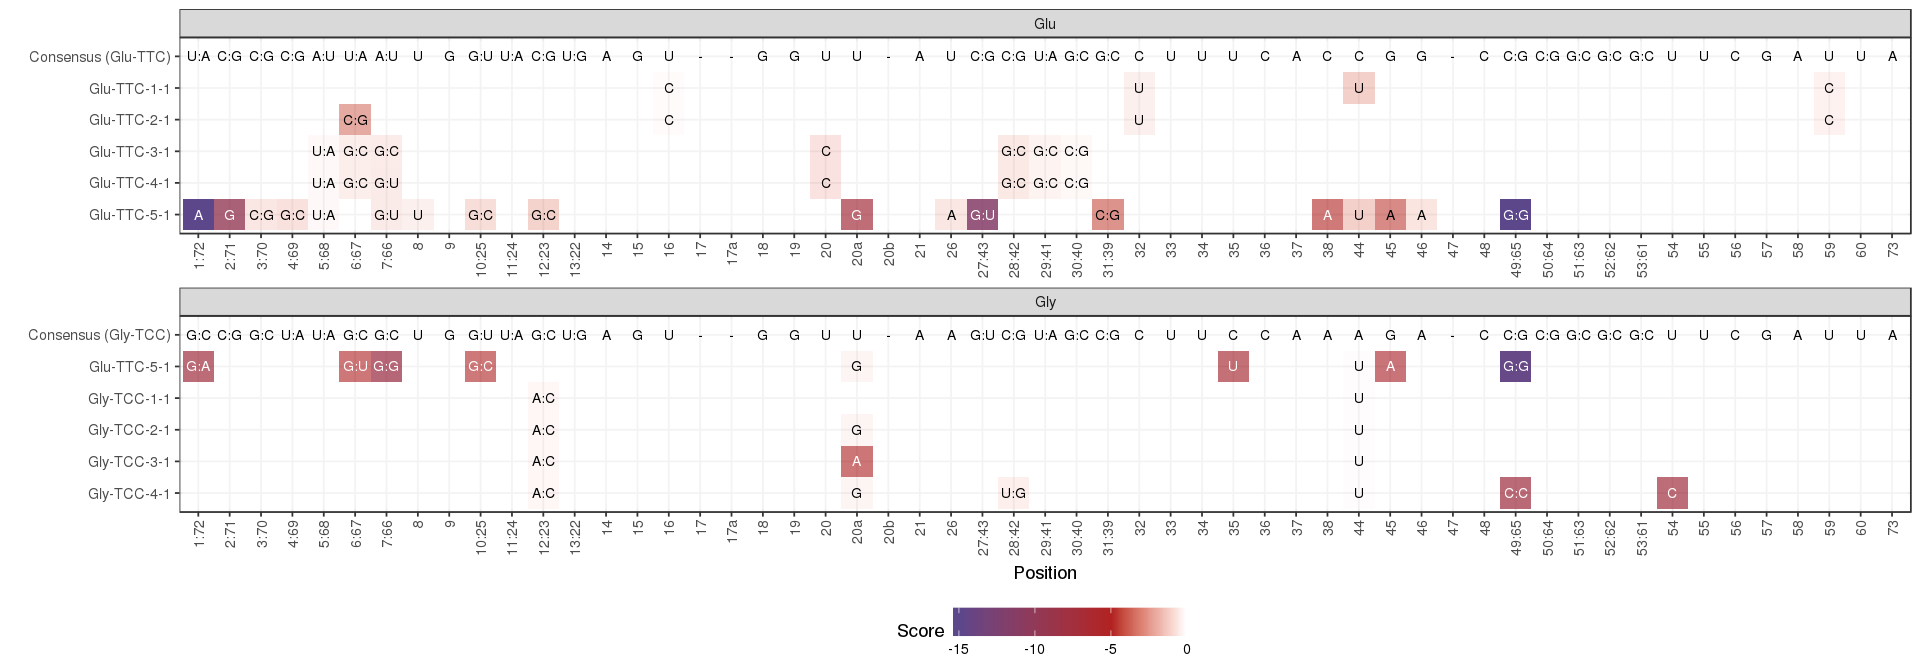

In [34]:
options(repr.plot.width=16, repr.plot.height=5.6)
plot